<a href="https://colab.research.google.com/github/wheemin-2/24-2-ESAA/blob/main/1108_HW_Regression_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **회귀 (2)**

## **규제 선형 모델**

회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어할 수 있어야함

ex) Degree 15 : 다항식이 복잡해지고 회귀 계수가 매우 크게 설정이 되면서 과적합이 됨

**비용 함수 목표의 변화**

RSS 최소화 + 회귀 계수 크기 제어(과적합 방지)를 목표로 함

![Cost function](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcStYSWh8sKTVYoRXKh9n3OeZb-6w5bff7EU4Q&s)


$ Min(RSS(W) + alpha * \parallel W \parallel^{2}_{2}) $ : 이 식을 만족하는 W 벡터를 찾는 것이 비용함수의 목표

*alpha는 학습 데이터 적합 정도와 회귀 계수 값의 크기를 제어하는 튜닝 파라미터*

**alpha의 역할**

* alpha ↑ : W의 값을 작게 해 과적합을 개선
* alpha ↓ : W의 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선할 수 있음 (alpha = 0인 경우 Min(RSS(W)))

*비용 함수에 alpha 값으로 페널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식이 **'규제(Regularization)'**\*

   * L2 규제 : W의 제곱에 대해 페널티를 부여, 릿지(Ridge) 회귀
   * L1 규제 : W의 절댓값에 페널티를 부여, 라쏘(Lasso) 회귀

## **릿지 회귀**

예시. 보스턴 주택 가격을 Ridge 클래스를 이용하여 예측하고 예측 성능을 cross_val_score() 로 평가

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# data load
import pandas as pd
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE']
boston = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/housing.csv', header=None, delimiter=r'\s+', names=column_names)
bostonDF = pd.DataFrame(boston)
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
# feature/target split
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)
y_target = bostonDF['PRICE']

In [4]:
X_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [5]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# alpha=10으로 설정 후 릿지 회귀 수행
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

In [6]:
print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE :{0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE :5.518


In [7]:
# ridge의 alpha값 변화시키면서 성능 확인

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788
alpha 1 일 때 5 folds의 평균 RMSE : 5.653
alpha 10 일 때 5 folds의 평균 RMSE : 5.518
alpha 100 일 때 5 folds의 평균 RMSE : 5.330


alpha = 100일 때 가장 좋은 결과

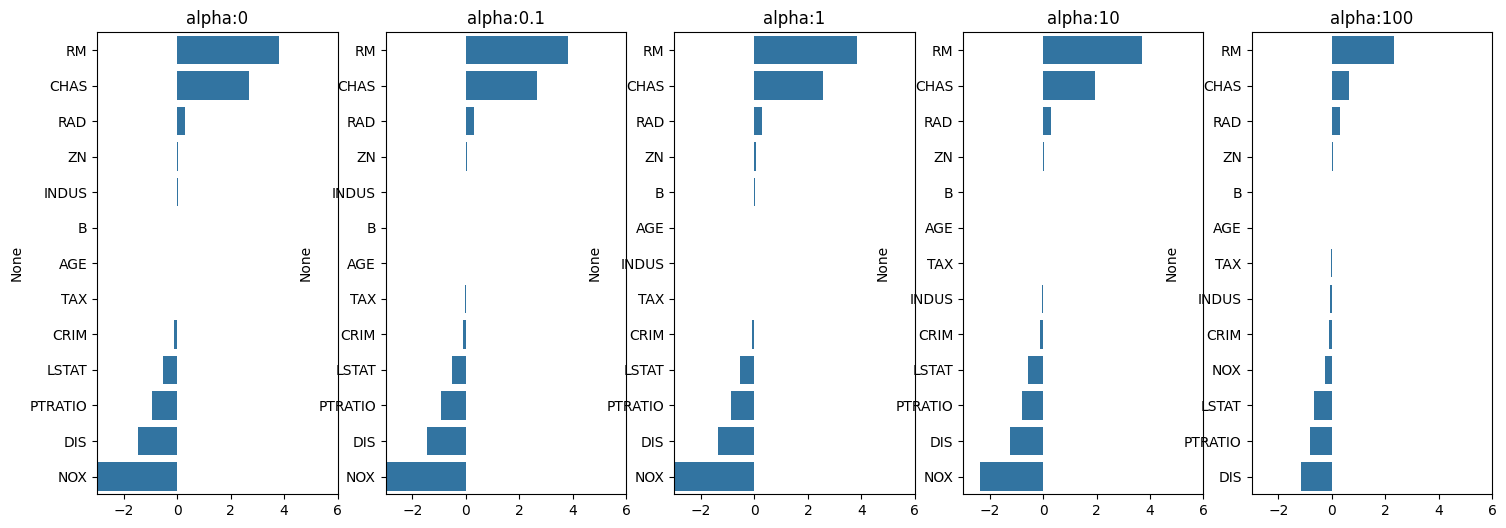

In [8]:
# alpha 값의 변화에 따른 피처의 회귀 계수 값 시각화

import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)

# 각 alpha에 따른 coef를 저장하기 위한 DataFrame
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)

    # alpha에 다른 피처별 회귀 계수를 series 형태로 저장 > DataFrame 칼럼으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname] = coeff

    # 시각화
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

alpha값을 증가시킬수록 회귀 계수의 값은 지속적으로 작아진다 (특히 NOX)

In [9]:
ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있다.

하지만 릿지 회귀의 경우에는 회귀 계수를 0으로 만들지는 않음! (라쏘는 0으로 만듦)

## **라쏘 회귀**

W의 절댓값에 페널티를 부여하는 L1 규제를 선형 회귀에 적용한 것



**라쏘 회귀 비용함수의 목표**

$ RSS(W) + alpha * \parallel W \parallel_{1} $ 최소화!!

여기서 $alpha * \parallel W \parallel_{1}$ 이 부분이 L1 규제를 의미

* L2 규제 : 회귀 계수의 크기를 감소시킴

* L1 규제 : 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
> 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가짐 !

In [12]:
from sklearn.linear_model import Lasso, ElasticNet

In [13]:
# alpha 값에 다른 폴드 평균 RMSE 출력 + coefficient DataFrame 형태로 반환하는 함수 생성

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):

    coeff_df = pd.DataFrame()
    # verbose = True인 경우 진행 상황 출력
    if verbose : print('######', model_name, '######')

    # params : alpha를 의미
    for param in params :
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0} 일 때 5 folds 의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))

        # 회귀 계수 추출 (fit, coef_ 로 추출)
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff

    return coeff_df


In [ ]:
# 라쏘에 사용될 alpha 값들을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n = X_data, y_target_n=y_target)

###### Lasso ######
alpha 0.07 일 때 5 folds 의 평균 RMSE: 5.612
alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.615
alpha 0.5 일 때 5 folds 의 평균 RMSE: 5.669
alpha 1 일 때 5 folds 의 평균 RMSE: 5.776
alpha 3 일 때 5 folds 의 평균 RMSE: 6.189


alpha 가 0.07일 때 가장 좋은 결과 (릿지보다는 약간 떨어지지만 기본 LinearRegression 평균 보다는 향상됨)

In [ ]:
# alpha값에 따른 피처별 회귀 계수
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 아예 0으로 바뀌고 있는 것이 확인됨

* NOX는 0.07일 때부터 0
* INDUS, CHAS는 점점 0으로 바뀜
* 회귀계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

## **엘라스틱넷 회귀**

L2 규제와 L1 규제를 결합한 회귀

**엘라스틱넷 회귀 비용함수의 목표**


$ RSS(W) + alpha2 * \parallel W \parallel^{2}_{2} + alpha1 * \parallel W \parallel_{1} $ 최소화!!

* 라쏘 회귀 : 서로 상관관계가 높은 피처들의 경우, 이들 중 중요 피처만 선택하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함     >> alpha 값에 따라 회귀 계수의 값이 급격히 변동할 수도 있음

* 엘라스틱넷 회귀 : 라쏘 회귀에서의 단점을 완화하기 위해 L2 규제를 추가한 것, 수행시간이 상대적으로 길다





```
ElasticNet(alpha, l1_ratio)
```
* 엘라스틱넷의 규제 : a * L1 + b * L2
    * a : L1 규제의 alpha 값 (alpha1)
    * b : L2 규제의 alpha 값 (alpha2)
* alpha : a + b
* l1_ratio : a / (a+b)
    * l1_ratio = 0  : Ridge (L2 규제)
    * l1_ratio = 1  : Lasso (L1 규제)



In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio = 0.7로 고정 (함수 내에서 고정했음)

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n = X_data, y_target_n = y_target)

###### ElasticNet ######
alpha 0.07 일 때 5 folds 의 평균 RMSE: 5.542
alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.526
alpha 0.5 일 때 5 folds 의 평균 RMSE: 5.467
alpha 1 일 때 5 folds 의 평균 RMSE: 5.597
alpha 3 일 때 5 folds 의 평균 RMSE: 6.068


alpha 가 0.5일 때 결과가 가장 좋음

In [ ]:
# 회귀 계수 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha 값에 따른 피처들의 회귀 계수 값이 라쏘보다는 상대적으로 0이 되는 값이 적다

## **선형 회귀 모델을 위한 데이터 변환**

선형 회귀 모델과 같은 선형 모델은 일반적으로 **피처와 타깃값 간에 선형 관계가 있다고 가정**하고 최적의 선형함수를 찾아내 결과값을 예측함

**선형 회귀 모델**

* 피처, 타깃값의 분포가 정규 분포인 것을 선호
* 타깃값 : Skewed distributed 인 경우 예측 성능에 부정적인 영향을 미칠 가능성 ↑
* 피처값 : 타깃값보다는 덜하지만 왜곡된 분포도가 예측 성능에 부정적인 영향을 미칠 수 있음

  \>>> 선형 회귀 모델을 적용하기 전, 먼저 데이터 스케일링/정규화 작업을 수행하는 것이 일반적
  



**피처 데이터 세트 변환 방법**

* StandardScaler() : 평균이 0, 분산이 1인 표준 정규분포로 변환
* MinMaxScaler() : 최솟값이 0, 최댓값이 1인 값으로 정규화
* 스케일링/정규화 + 다항 특성 적용
* 로그 변환(Log Transform)

**타깃값 변환**

* 일반적으로 로그 변환을 적용
    * 결정값을 정규분포 또는 다른 정규값으로 변환하면 다시 원본 타깃값으로 복구하기 어려울 수 있기 때문
    * 왜곡된 분포도 형태의 타깃값을 로그 변환하여 예측 성능이 향상된 경우가 많이 검증됨

In [10]:
# 보스턴 주택가격 피처 데이터 세트에 데이터 스케일링/정규화 적용

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method : Standard/MinMax/Log transform 결정
# p_degree : 다항식 특성을 추가할 때 적용, 2 이상 부여하지 않음
def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else :
        scaled_data = input_data

    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

    return scaled_data


In [14]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

scale_methods = [(None, None), ('Standard', None), ('Standard',2), ('MinMax', None), ('MinMax',2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data = X_data)
    print('\n ## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n = y_target, verbose=False, return_coeff=False)


 ## 변환 유형:None, Polynomial Degree:None
alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.788
alpha 1 일 때 5 folds 의 평균 RMSE: 5.653
alpha 10 일 때 5 folds 의 평균 RMSE: 5.518
alpha 100 일 때 5 folds 의 평균 RMSE: 5.330

 ## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.826
alpha 1 일 때 5 folds 의 평균 RMSE: 5.803
alpha 10 일 때 5 folds 의 평균 RMSE: 5.637
alpha 100 일 때 5 folds 의 평균 RMSE: 5.421

 ## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1 일 때 5 folds 의 평균 RMSE: 8.827
alpha 1 일 때 5 folds 의 평균 RMSE: 6.871
alpha 10 일 때 5 folds 의 평균 RMSE: 5.485
alpha 100 일 때 5 folds 의 평균 RMSE: 4.634

 ## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.764
alpha 1 일 때 5 folds 의 평균 RMSE: 5.465
alpha 10 일 때 5 folds 의 평균 RMSE: 5.754
alpha 100 일 때 5 folds 의 평균 RMSE: 7.635

 ## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.298
alpha 1 일 때 5 folds 의 평균 RMSE: 4.323
alpha 10 일 때 5 folds 의 평균 RMSE: 5.185
alpha 100 일 때 5 folds 의 평균 RMSE: 6.538

 ## 변환 유형:Log, Polynomial De

로그 변환시 좋은 성능 향상이 있음(alpha=100 제외 모두 4점대)

MinMax 정규화 후 2차 다항식 변환시 성능이 개선되었으나 피처의 개수가 많거나 데이터 수가 많으면 계산에 많은 시간이 소요됨

## **로지스틱 회귀**

선형 회귀 방식을 분류에 적용한 알고리즘

* 분류에 사용되며, 선형 회귀 계열이다!
* 선형/비선형 회귀 : 독립변수(X) 가 아닌 W 파라미터가 선형인지 아닌지를 따짐

**로지스틱 회귀 vs. 선형 회귀**

* 로지스틱 회귀는 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드(Sigmoid) 함수 최적선을 찾고, 이 시그모이드 함수의 반환값을 확률로 간주해 확률에 따라 분류를 결정한다 !!

 ![linear and sigmoid](https://velog.velcdn.com/images/oneman98/post/0e2fff24-1cb8-4f01-807c-1847bc6384ec/image.png)

**시그모이드(Sigmoid) 함수**

* 많은 자연, 사회 현상에서 특정 변수의 확률 값은 선형이 아니라 시그모이드 함수와 같은 S자 커브 형태를 가짐

* 시그모이드 함수식 : $y=\frac{1}{1+e^{-x}}$
    * y값 : 항상 0과 1 사이

* 로지스틱 회귀를 이용하여 분류 수행

 ![logistic regression](https://thebook.io/img/080263/089.jpg)

    * 선형회귀 : 회귀선이 0과 1을 제대로 분류하지 못 함 (정확도 ↓)
    * 시그모이드 함수 : 좀 더 정확하게 0과 1을 분류할 수 있음

*로지스틱 회귀 : 선형 회귀 방식을 기반으로 하되, 시그모이드 함수를 이용해 분류를 수행하는 회귀*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
# 데이터 스케일링
# 선형 회귀 계열의 로지스틱 회귀는 피처 데이터의 정규 분포 여부에 따라 예측 성능이 영향을 받을 수 있음

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler() 객체 생성 : 평균 0, 분산 1로 데이터 분포 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습/예측 수행
# solver='lbfgs' 가 default (solver : 최적화 방안)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

# accuracy, roc_auc 측정
print('accuracy: {0:.3f}, roc_auc: {1:.3f}'.format(accuracy_score(lr_preds, y_test), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc: 0.995


In [ ]:
# 여러개의 solver 값 별로 LogisticRegression 학습 후 성능 평가
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

for solver in solvers:
    # 특정 solver는 최적화에 많은 반복 횟수가 필요할 수 있으므로 max_iter = 600으로 지정
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:,1]

    # accuracy, roc_auc 측정
    print('solver : {0}, accuracy : {1:.3f}, roc_auc : {2:.3f}'.format(solver,
                                                        accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

solver : lbfgs, accuracy : 0.977, roc_auc : 0.995
solver : liblinear, accuracy : 0.982, roc_auc : 0.995
solver : newton-cg, accuracy : 0.977, roc_auc : 0.995
solver : sag, accuracy : 0.982, roc_auc : 0.995
solver : saga, accuracy : 0.982, roc_auc : 0.995


데이터 세트가 작기 때문에 개별 solver별 성능 결과의 차이가 크게 의미 있지는 않음

보통 lbfgs / liblinear 를 선택

**LogisticRegression 클래스의 주요 하이퍼 파라미터**

* solver : 최적화 방안
* max_iter : 최적화 알고리즘이 최적 수렴할 수 있는 최대 반복 횟수
* penalty : 규제(Regularization)의 유형을 설정
    * 'l1' : L1 규제
    * 'l2' : L2 규제
* C : 규제 강도를 조절하는 alpha 값의 역수, $\frac{1}{alpha}$

    * C 값이 작을수록 규제 강도가 큼

*solver에 따라 적용할 수 있는 규제가 다름*

In [ ]:
# LogisticRegression 클래스의 주요 하이퍼 파라미터(solver, penalty, C) 튜닝
from sklearn.model_selection import GridSearchCV

params = {'solver':['liblinear','lbfgs'],
          'penalty':['l2','l1'],
          'C':[0.01,0.1,1,5,10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

FitFailedWarning 메시지 : solver = 'lbfgs'일 때 L1 규제를 지원하지 않음에도 GridSearchCV에서 L1 규제값을 입력했기 때문에 출력됨



---



## **회귀 트리**

트리 기반의 회귀란?

: *회귀 트리를 이용하는 것, 즉 회귀 트리를 생성하고 이를 기반으로 회귀 예측을 수행함*

**분류 트리 vs. 회귀 트리**

* 분류 트리 : 특정 클래스 레이블을 결정
* 회귀 트리 : 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산

(회귀 트리 동작 예시)

* 데이터 세트 분포

 ![step1](https://cdn.imweb.me/thumbnail/20221206/a66c9718d397a.png)


* X 피처 분할 (결정 트리를 기반으로)

    *X값의 균일도를 반영한 지니 계수에 따라 Split0 > Split1, Split2 > Split3... 규칙 노드로 분할*

 ![step2](https://cdn.imweb.me/upload/S202209290989f2bea459e/575a0f053af46.png)

* 최종 결정 값 할당
    
    *리프 노드에 소속된 데이터 값의 평균값을 구해 최종적으로 리프 노드에 결정값으로 할당*

 ![step3](https://cdn.imweb.me/upload/S202209290989f2bea459e/6f05351e5f1d1.png)

결정트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 등의 모든 트리 기반 알고리즘은 분류 + 회귀 모두 가능

In [ ]:
# RandomForestRegressor를 이용해 보스턴 주택 가격 예측 수행
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
av_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores,2))
print(' 5 교차 검증의 개별 RMSE scores:', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE:{0:.3f}'.format(av_rmse))

 5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores: [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE:4.423


In [ ]:
# Regressor 모델, 데이터 세트를 입력 받아 교차 검증으로 평균 RMSE를 계산하는 함수 생성
def get_model_cv_prediction(model, X_data_n, y_target_n):
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse)
    print('#####', model.__class__.__name__, '#####')
    print('5 교차 검증의 평균 RMSE:{0:.3f}'.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000, verbose=-1)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

##### DecisionTreeRegressor #####
5 교차 검증의 평균 RMSE:5.978
##### RandomForestRegressor #####
5 교차 검증의 평균 RMSE:4.423
##### GradientBoostingRegressor #####
5 교차 검증의 평균 RMSE:4.269
##### XGBRegressor #####
5 교차 검증의 평균 RMSE:4.959
##### LGBMRegressor #####
5 교차 검증의 평균 RMSE:4.646


회귀 트리 Regressor 클래스는 선형 회귀와 처리 방식이 다르기 때문에 회귀 계수를 제공하는 coef_ 속성이 없음

**feature_importance_**를 이용하여 피처별 중요도를 확인할 수 있음

<Axes: xlabel='None', ylabel='None'>

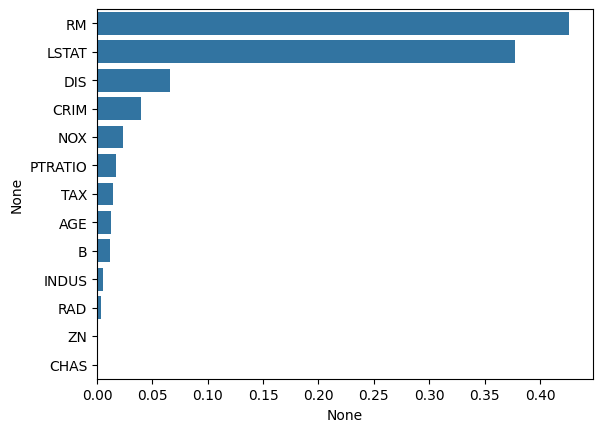

In [ ]:
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)



---



### **회귀 트리 Regressor가 예측값을 판단하는 방식 (vs. 선형회귀)**

* 결정 트리의 하이퍼 파라미터인 max_depth를 변경시키면서 회귀 트리 예측선이 어떻게 변화하는지 시각화
* 2차원 평면상에 회귀 예측선을 쉽게 표현하기 위해 'PRICE'와 가장 밀접한 양의 상관관계를 가지는 'RM' 칼럼만 이용하여 회귀선 표현

(100, 2)


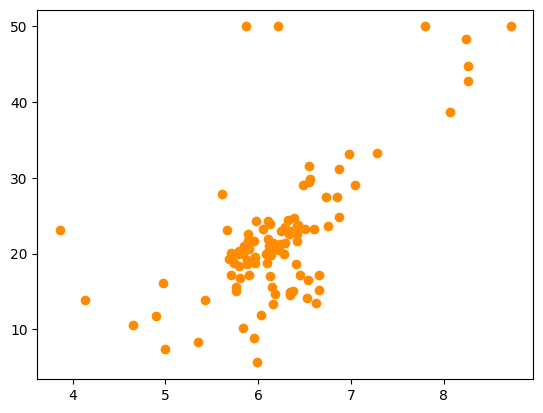

In [ ]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(x=bostonDF_sample.RM, y=bostonDF_sample.PRICE, c='darkorange')

In [ ]:
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성, DecisionTreeRegressor의 max_depth는 각각 2, 7
lr_reg = LinearRegression()
dt_reg2 = DecisionTreeRegressor(max_depth=2)
dt_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만 사용
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습/예측 수행
lr_reg.fit(X_feature, y_target)
dt_reg2.fit(X_feature, y_target)
dt_reg7.fit(X_feature, y_target)

# 예측값 저장
pred_lr = lr_reg.predict(X_test)
pred_dt2 = dt_reg2.predict(X_test)
pred_dt7 = dt_reg7.predict(X_test)

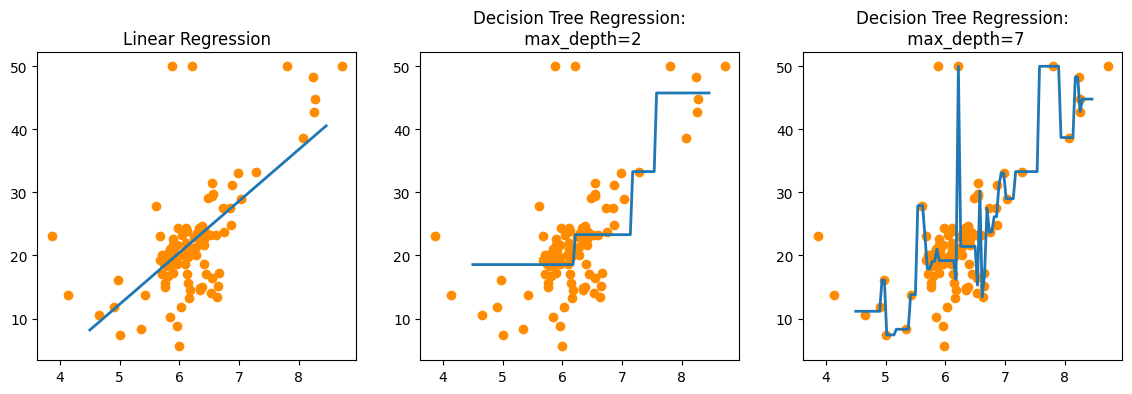

In [ ]:
# 회귀선 시각화

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), ncols=3)

ax1.set_title('Linear Regression')
ax1.scatter(x=bostonDF_sample.RM, y=bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

ax2.set_title('Decision Tree Regression:\n max_depth=2')
ax2.scatter(x=bostonDF_sample.RM, y=bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_dt2, label='max_depth:2', linewidth=2)

ax3.set_title('Decision Tree Regression:\n max_depth=7')
ax3.scatter(x=bostonDF_sample.RM, y=bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_dt7, label='max_depth:7', linewidth=2)


*결과*

* 선형 회귀 : 직선으로 예측 회귀선을 표현
* 회귀 트리 : 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만듦
    * max_depth=7 의 경우, outlier도 학습하면서 복잡한 계단 형태의 회귀선을 만듦 > 과적합이 되기 쉬운 모델이 됨